In [7]:
import os

import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use('seaborn-whitegrid')
import itertools
import warnings
warnings.filterwarnings('ignore')

In [8]:
import yfinance as yf

start = "2014-09-17"
end = "2024-02-14"
symbol = {"^GSPC"}
df = yf.download(symbol, start, end, auto_adjust=True)

df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,1999.300049,2010.739990,1993.290039,2001.569946,3209420000
2014-09-18,2003.069946,2012.339966,2003.069946,2011.359985,3235340000
2014-09-19,2012.739990,2019.260010,2006.589966,2010.400024,4880220000
2014-09-22,2009.079956,2009.079956,1991.010010,1994.290039,3349670000
2014-09-23,1992.780029,1995.410034,1982.770020,1982.770020,3279350000


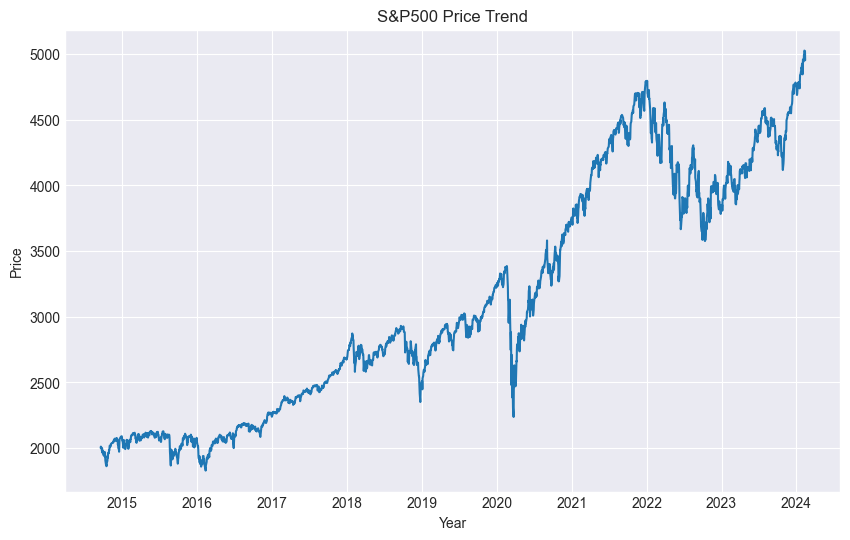

In [9]:
# Plot the time series data to understand its patterns and trends

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title("S&P500 Price Trend")
plt.plot(df['Close'])


In [10]:
from statsmodels.tsa.stattools import adfuller
# If data is not stationary according to the ADF test, it has to be converted into a stationary data for building up Machine Learning Model.
# Define a function to perform the Augmented Dickey-Fuller (ADF) test

def augmented_dickey_fuller_test(timeseries):
    # Perform the ADF test
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # Print the results
    print('Results of Dickey-Fuller Test for S&P500:')
    # Create a pandas Series to display the test statistics, p-value, number of lags used, and number of observations used
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    # Add critical values to the Series
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    # Print the Series containing test results
    print(dfoutput)
    
    # Determine stationarity
    if dftest[1] > 0.05:
        print("Is Stationary: No (fail to reject)")
    else:
        print("Is Stationary: Yes (reject)")

# Call the function to perform the ADF test
print(augmented_dickey_fuller_test(df['Close']))

Results of Dickey-Fuller Test for S&P500:
Test Statistic                   -0.223227
p-value                           0.935696
#Lags Used                       10.000000
Number of Observations Used    2357.000000
Critical Value (1%)              -3.433127
Critical Value (5%)              -2.862767
Critical Value (10%)             -2.567423
dtype: float64
Is Stationary: No (fail to reject)
None


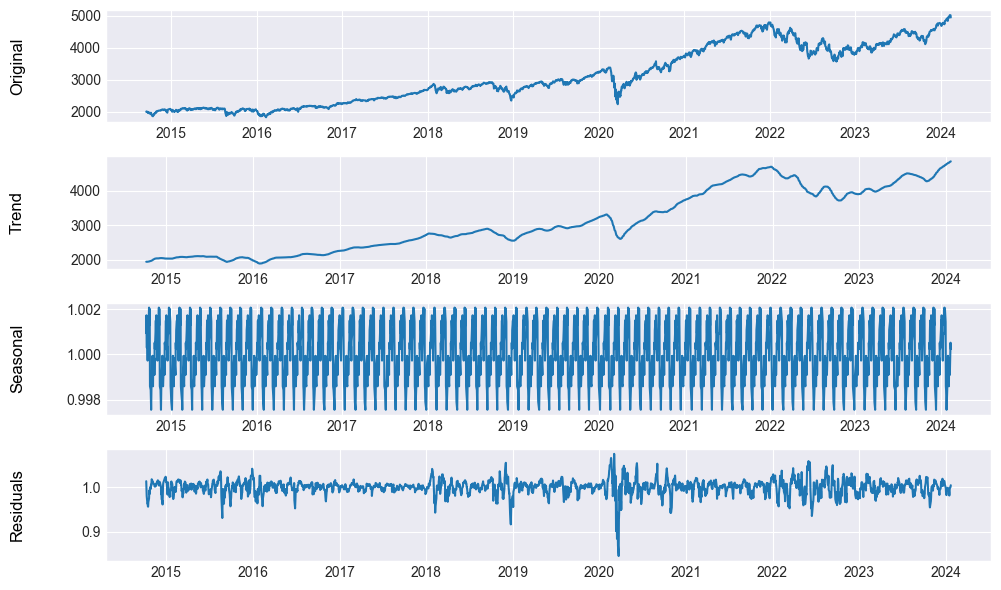

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform Time Series Data Decomposition since it helps in understanding the underlying structure and preparing the data for further analysis or modeling.

decomposition = seasonal_decompose(df["Close"], model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 6))
# Original
plt.subplot(411)
plt.plot(df["Close"], label='original')
plt.annotate('Original', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Trend
plt.subplot(412)
plt.plot(trend, label='trend')
plt.annotate('Trend', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Seasonality
plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.annotate('Seasonal', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Residuals
plt.subplot(414)
plt.plot(residual, label='residuals')
plt.annotate('Residuals', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

plt.tight_layout()
plt.show()

In [12]:
# Check the trend's staionary after decomposition : NO

trend.dropna(inplace=True)
augmented_dickey_fuller_test(trend)

Results of Dickey-Fuller Test for S&P500:
Test Statistic                    0.447441
p-value                           0.983185
#Lags Used                       27.000000
Number of Observations Used    2310.000000
Critical Value (1%)              -3.433184
Critical Value (5%)              -2.862792
Critical Value (10%)             -2.567437
dtype: float64
Is Stationary: No (fail to reject)


In [13]:
# split 8 : 2
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

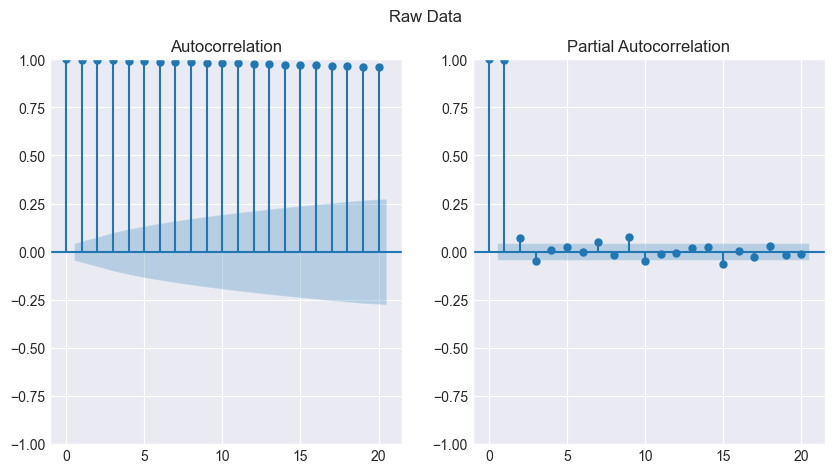

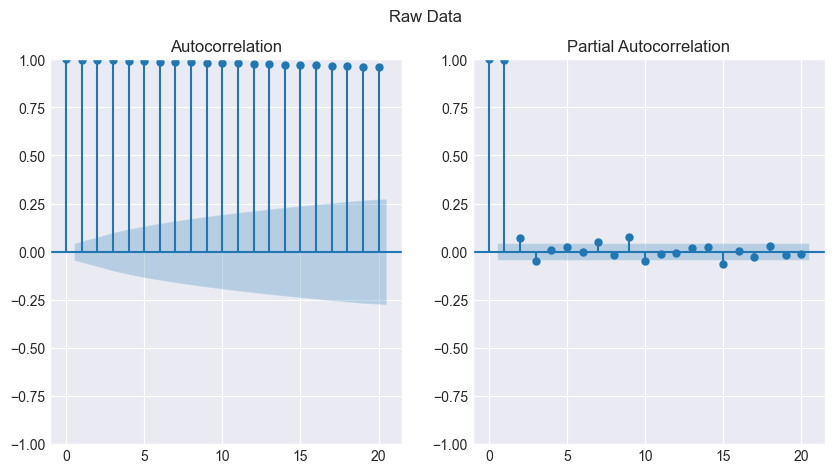

In [14]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data['Close'].values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data['Close'].values.squeeze(), lags=20, ax=ax[1])

In [15]:
# Non-stationary -> stationary 보정 (차분, difference)
# differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['Close'].diff() # 차분
diff_train_data = diff_train_data.dropna() # 차분 후 생기는 결측치 제거
print()
print(train_data['Close'].head())
print()
print(diff_train_data.head())


Date
2014-09-17    2001.569946
2014-09-18    2011.359985
2014-09-19    2010.400024
2014-09-22    1994.290039
2014-09-23    1982.770020
Name: Close, dtype: float64

Date
2014-09-18     9.790039
2014-09-19    -0.959961
2014-09-22   -16.109985
2014-09-23   -11.520020
2014-09-24    15.530029
Name: Close, dtype: float64


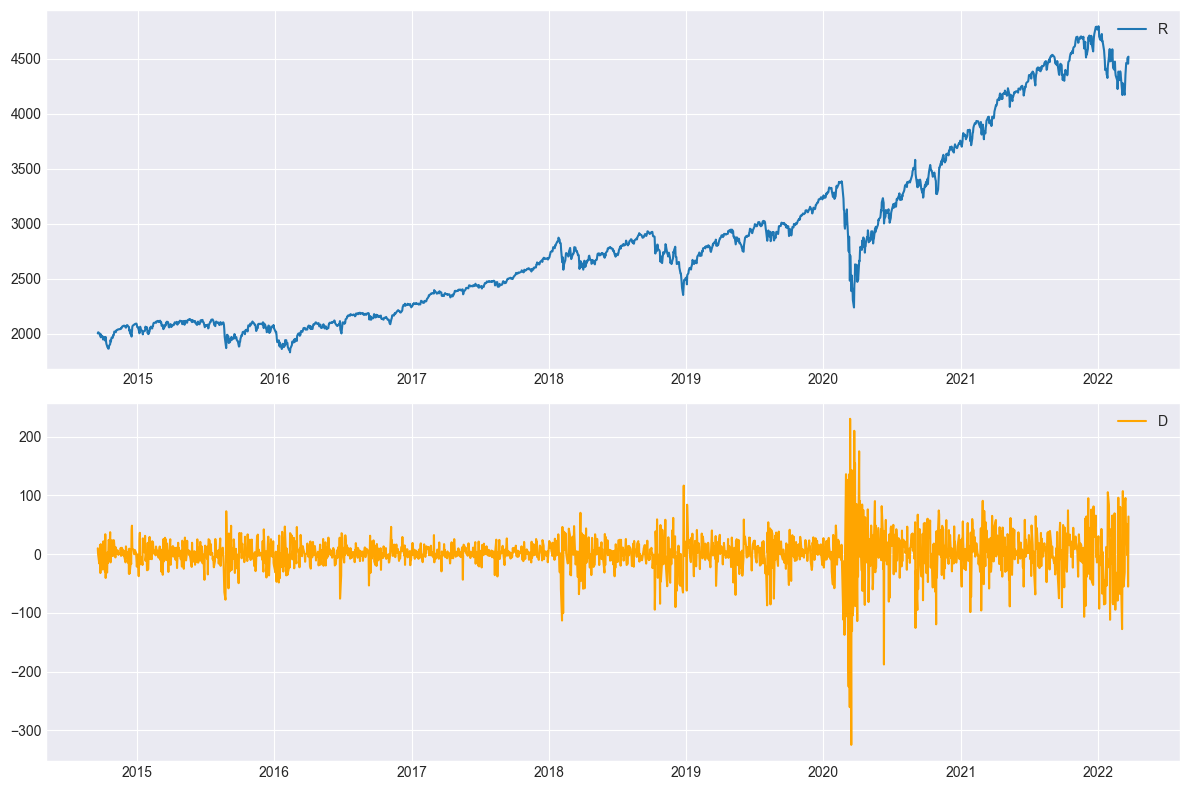

In [16]:
# 차분 시각화

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(train_data['Close'])
ax1.legend('Raw data (Non-stationary)')

ax2.plot(diff_train_data, color='orange' )
ax2.legend('Differenced data (stationary)')


plt.tight_layout()
plt.show()

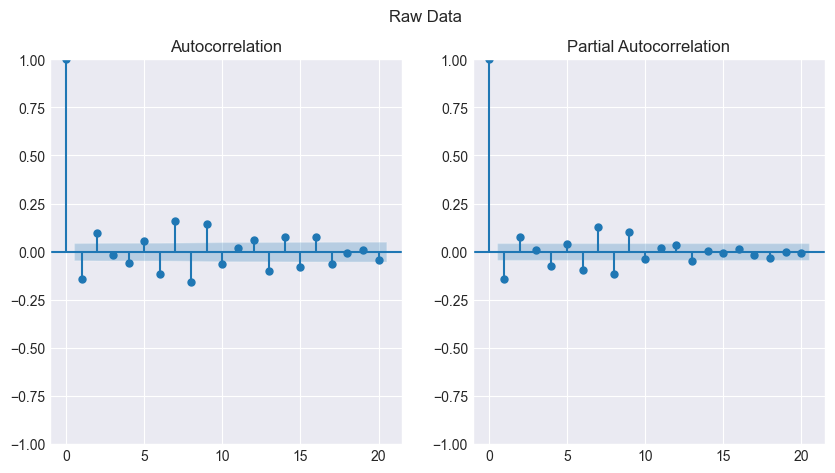

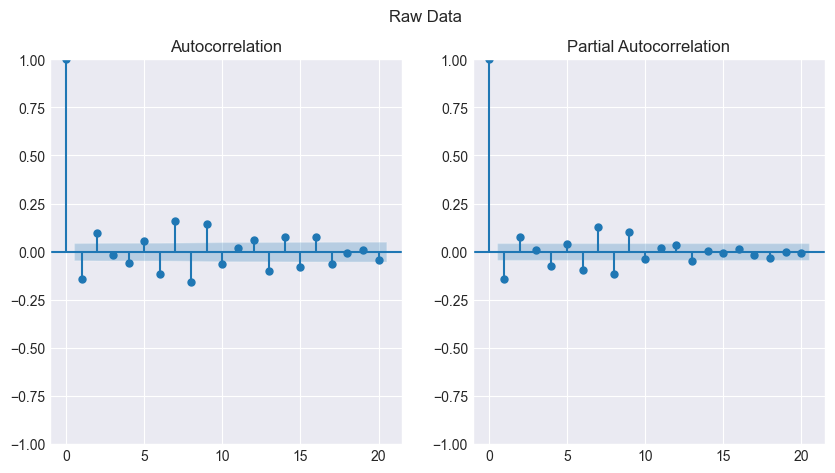

In [17]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=20, ax=ax[1])

In [18]:
# parameter search

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in pdq]

AIC = []
params = []
for i in pdq :
    for j in seasonal_pdq :
        try : 
            model = SARIMAX(train_data['Close'].values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA : {i},{j} >> AIC : {round(model_fit.aic, 2)}')
            AIC.append(round(model_fit.aic, 2))
            params.append((i, j))
            
        except Exception as e:
            print(e)
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24488D+00    |proj g|=  4.55727D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   4.219D-08   5.245D+00
  F =   5.2448812351281715     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(0, 1, 0, 3) >> AIC : 19869.61
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.89564D+00    |proj g|=  2.80965D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     13      1     0     0   9.925D-07   4.896D+00
  F =   4.8956379017837124     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(0, 1, 1, 3) >> AIC : 18548.68
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.92196D+00    |proj g|=  7.58445D-02


 This problem is unconstrained.



At iterate    5    f=  4.91157D+00    |proj g|=  4.07529D-02

At iterate   10    f=  4.89547D+00    |proj g|=  2.22216D-04

At iterate   15    f=  4.89540D+00    |proj g|=  7.87451D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     21      1     0     0   2.773D-06   4.895D+00
  F =   4.8953605355594867     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(0, 1, 2, 3) >> AIC : 18549.63
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.91144D+00    |proj g|=  5.51067D-03

At iterate   10    f=  4.89579D+00    |proj g|=  1.73858D-03

At iterate   15    f=  4.89543D+00    |proj g|=  3.14834D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     22      1     0     0   7.197D-06   4.895D+00
  F =   4.8954267728348650     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(1, 1, 1, 3) >> AIC : 18549.88
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f=  4.90148D+00    |proj g|=  4.86694D-03

At iterate   10    f=  4.89246D+00    |proj g|=  8.67199D-04

At iterate   15    f=  4.89230D+00    |proj g|=  5.05120D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   5.871D-06   4.892D+00
  F =   4.8922860676564932     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(1, 1, 2, 3) >> AIC : 18539.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.90877D+00    |proj g|=  6.39901D-02

At iterate   10    f=  4.89177D+00    |proj g|=  4.15147D-03

At iterate   15    f=  4.88788D+00    |proj g|=  1.06589D-04

At iterate   20    f=  4.88784D+00    |proj g|=  1.66778D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     27      1     0     0   3.659D-06   4.888D+00
  F =   4.8878361936828689     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 0),(2, 1, 1, 3) >> AIC : 18523.12
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  4.89280D+00    |proj g|=  3.96891D-03

At iterate   10    f=  4.88511D+00    |proj g|=  3.39347D-02

At iterate   15    f=  4.88369D+00    |proj g|=  2.76511D-04

At iterate   20    f=  4.88369D+00    |proj g|=  7.20926D-04

At iterate   25    f=  4.88368D+00    |proj g|=  1.04335D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   1.353D-05   4.884D+00
  F =   4.8836842586222176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 0),(2, 1, 2, 3) >> AIC : 18509.4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision =

 This problem is unconstrained.



At iterate    5    f=  5.23382D+00    |proj g|=  5.66436D-04

At iterate   10    f=  5.23376D+00    |proj g|=  3.82798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     15      1     0     0   5.658D-06   5.234D+00
  F =   5.2337544461598027     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(0, 1, 0, 3) >> AIC : 19829.46
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01756D+00    |proj g|=  4.19794D-02


 This problem is unconstrained.



At iterate    5    f=  4.97205D+00    |proj g|=  1.05084D-02

At iterate   10    f=  4.88701D+00    |proj g|=  3.60974D-04

At iterate   15    f=  4.88699D+00    |proj g|=  3.87593D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   2.264D-06   4.887D+00
  F =   4.8869130620334129     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(0, 1, 1, 3) >> AIC : 18517.63
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f=  4.98102D+00    |proj g|=  5.95959D-02

At iterate   10    f=  4.88698D+00    |proj g|=  1.59792D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   3.897D-06   4.887D+00
  F =   4.8867569089525880     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(0, 1, 2, 3) >> AIC : 18519.04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13292D+00    |proj g|=  6.99648D-02

At iterate    5    

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   3.137D-06   5.115D+00
  F =   5.1152961258858580     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(1, 1, 0, 3) >> AIC : 19382.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01684D+00    |proj g|=  7.13866D-02


 This problem is unconstrained.



At iterate    5    f=  4.97402D+00    |proj g|=  1.31526D-02

At iterate   10    f=  4.88730D+00    |proj g|=  4.44878D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   1.493D-05   4.887D+00
  F =   4.8871329059484294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 1),(1, 1, 1, 3) >> AIC : 18520.46
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99751D+00    |proj g|=  2.11903D-02


 This problem is unconstrained.



At iterate    5    f=  4.96532D+00    |proj g|=  1.05195D-02

At iterate   10    f=  4.88650D+00    |proj g|=  3.29545D-04

At iterate   15    f=  4.88647D+00    |proj g|=  3.99620D-03

At iterate   20    f=  4.88620D+00    |proj g|=  8.79707D-04

At iterate   25    f=  4.88614D+00    |proj g|=  3.74484D-04

At iterate   30    f=  4.88597D+00    |proj g|=  3.42219D-04

At iterate   35    f=  4.88595D+00    |proj g|=  1.30314D-04

At iterate   40    f=  4.88595D+00    |proj g|=  1.33681D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     49      1     0     0   8.257D-06   4.886D+00
  F =   4.88595180465

 This problem is unconstrained.



At iterate   10    f=  4.99947D+00    |proj g|=  1.76164D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   7.885D-05   4.999D+00
  F =   4.9992219724452243     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 1),(2, 1, 0, 3) >> AIC : 18945.05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02328D+00    |proj g|=  5.44662D-02


 This problem is unconstrained.



At iterate    5    f=  4.99239D+00    |proj g|=  2.25470D-02

At iterate   10    f=  4.92560D+00    |proj g|=  1.16148D-01

At iterate   15    f=  4.88230D+00    |proj g|=  3.61218D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     20      1     0     0   7.037D-06   4.882D+00
  F =   4.8823000468119728     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 1),(2, 1, 1, 3) >> AIC : 18504.15
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f=  4.98117D+00    |proj g|=  1.10117D-02

At iterate   10    f=  4.88608D+00    |proj g|=  8.76178D-04

At iterate   15    f=  4.88608D+00    |proj g|=  5.07564D-04

At iterate   20    f=  4.88606D+00    |proj g|=  1.53629D-03

At iterate   25    f=  4.88604D+00    |proj g|=  2.22077D-03

At iterate   30    f=  4.88590D+00    |proj g|=  3.66306D-03

At iterate   35    f=  4.88581D+00    |proj g|=  2.79497D-04

At iterate   40    f=  4.88580D+00    |proj g|=  8.92862D-05

At iterate   45    f=  4.88580D+00    |proj g|=  6.30579D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     54   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.23648D+00    |proj g|=  7.53655D-02

At iterate    5    f=  5.23105D+00    |proj g|=  4.17207D-02

At iterate   10    f=  5.22606D+00    |proj g|=  3.24870D-03

At iterate   15    f=  5.22576D+00    |proj g|=  3.18425D-04

At iterate   20    f=  5.22547D+00    |proj g|=  2.20536D-02

At iterate   25    f=  5.22247D+00    |proj g|=  8.33324D-03

At iterate   30    f=  5.22207D+00    |proj g|=  1.69560D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  4.97791D+00    |proj g|=  4.91130D-02

At iterate   10    f=  4.88263D+00    |proj g|=  9.83716D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   8.397D-06   4.882D+00
  F =   4.8824997232054601     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 2),(0, 1, 1, 3) >> AIC : 18502.91
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99306D+00    |proj g|=  5.55893D-02


 This problem is unconstrained.



At iterate    5    f=  4.97753D+00    |proj g|=  5.17498D-02

At iterate   10    f=  4.88369D+00    |proj g|=  4.90064D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   3.785D-06   4.882D+00
  F =   4.8815463676968527     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 2),(0, 1, 2, 3) >> AIC : 18501.3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12516D+00    |proj g|=  2.33873D-02


 This problem is unconstrained.



At iterate    5    f=  5.12391D+00    |proj g|=  1.31442D-02

At iterate   10    f=  5.11183D+00    |proj g|=  6.20074D-02

At iterate   15    f=  5.10954D+00    |proj g|=  4.40394D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   4.404D-06   5.110D+00
  F =   5.1095401872287889     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 2),(1, 1, 0, 3) >> AIC : 19362.94
RUNNING THE L-BFGS-B CODE



 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01197D+00    |proj g|=  7.80123D-02

At iterate    5    f=  4.98543D+00    |proj g|=  8.65028D-02

At iterate   10    f=  4.89676D+00    |proj g|=  1.34389D-01

At iterate   15    f=  4.88211D+00    |proj g|=  3.19461D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   1.103D-05   4.882D+00
  F =   4.8821100804166973     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 2),(1, 1, 1, 3) >> 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99318D+00    |proj g|=  3.16250D-02

At iterate    5    f=  4.97082D+00    |proj g|=  3.94742D-02

At iterate   10    f=  4.88223D+00    |proj g|=  7.21477D-04

At iterate   15    f=  4.88205D+00    |proj g|=  8.70831D-03

At iterate   20    f=  4.88165D+00    |proj g|=  1.63916D-04

At iterate   25    f=  4.88164D+00    |proj g|=  1.96396D-03

At iterate   30    f=  4.88144D+00    |proj g|=  6.15584D-03

At iterate   35    f=  4.88137D+00    |proj g|=  2.14633D-03

At iterate   40    f=  4.88130D+00    |proj g|=  1.93141D-04

At iterate   45    f=  4.88130D+00    |proj g|=  1.55178D-04

At iterate   50    f=  4.88129D+00    |proj g|=  1.19889D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.04572D+00    |proj g|=  1.66318D-02

At iterate   10    f=  5.00700D+00    |proj g|=  1.04781D-01

At iterate   15    f=  4.99832D+00    |proj g|=  3.32808D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   8.135D-06   4.998D+00
  F =   4.9983173931445348     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 2),(2, 1, 0, 3) >> AIC : 18943.63
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate   10    f=  4.91187D+00    |proj g|=  1.03058D-01

At iterate   15    f=  4.87871D+00    |proj g|=  2.75707D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   1.449D-05   4.879D+00
  F =   4.8787110138419338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 2),(2, 1, 1, 3) >> AIC : 18492.56
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00828D+00    |proj g|=  4.49031D-02


 This problem is unconstrained.



At iterate    5    f=  4.97910D+00    |proj g|=  1.77691D-02

At iterate   10    f=  4.88855D+00    |proj g|=  6.51306D-02

At iterate   15    f=  4.88183D+00    |proj g|=  9.24534D-04

At iterate   20    f=  4.88181D+00    |proj g|=  4.05204D-03

At iterate   25    f=  4.88108D+00    |proj g|=  1.55733D-02

At iterate   30    f=  4.88093D+00    |proj g|=  1.06885D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     36      1     0     0   4.281D-05   4.881D+00
  F =   4.8809340262294958     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 2),(2, 1, 2, 3) >> AIC : 18502.98


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.23244D+00    |proj g|=  9.17287D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      3      1     0     0   2.066D-05   5.232D+00
  F =   5.2324434493393985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 0),(0, 1, 0, 3) >> AIC : 19824.5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are 

 This problem is unconstrained.



At iterate    5    f=  4.92889D+00    |proj g|=  1.38511D-01

At iterate   10    f=  4.88523D+00    |proj g|=  1.14002D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   4.571D-06   4.885D+00
  F =   4.8852287840840871     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 0),(0, 1, 2, 3) >> AIC : 18513.25
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12594D+00    |proj g|=  3.33661D-02


 This problem is unconstrained.



At iterate    5    f=  5.12446D+00    |proj g|=  1.48112D-02

At iterate   10    f=  5.11314D+00    |proj g|=  3.97750D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   3.876D-06   5.111D+00
  F =   5.1114555825492101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 0),(1, 1, 0, 3) >> AIC : 19368.19
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01141D+00    |proj g|=  7.14909D-02


 This problem is unconstrained.



At iterate    5    f=  4.97273D+00    |proj g|=  1.90478D-02

At iterate   10    f=  4.88564D+00    |proj g|=  2.66387D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   1.096D-05   4.886D+00
  F =   4.8856380122899026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 0),(1, 1, 1, 3) >> AIC : 18514.8
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99230D+00    |proj g|=  2.43468D-02


 This problem is unconstrained.



At iterate    5    f=  4.96113D+00    |proj g|=  1.04575D-02

At iterate   10    f=  4.88506D+00    |proj g|=  2.97254D-04

At iterate   15    f=  4.88486D+00    |proj g|=  6.01383D-03

At iterate   20    f=  4.88474D+00    |proj g|=  5.23249D-04

At iterate   25    f=  4.88455D+00    |proj g|=  4.01270D-04

At iterate   30    f=  4.88444D+00    |proj g|=  4.68199D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     44      1     0     0   3.789D-06   4.884D+00
  F =   4.8844257980764514     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 0),(1, 1, 2, 3) >> AIC : 18512.2
RU

 This problem is unconstrained.



At iterate    5    f=  5.03590D+00    |proj g|=  6.35482D-02

At iterate   10    f=  4.99891D+00    |proj g|=  4.38781D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   1.931D-06   4.999D+00
  F =   4.9988838626458998     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 0),(2, 1, 0, 3) >> AIC : 18943.77
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02047D+00    |proj g|=  5.45319D-02


 This problem is unconstrained.



At iterate    5    f=  4.98422D+00    |proj g|=  4.31106D-02

At iterate   10    f=  4.88340D+00    |proj g|=  4.25547D-02

At iterate   15    f=  4.88123D+00    |proj g|=  8.14533D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   3.753D-05   4.881D+00
  F =   4.8812265443584861     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 0),(2, 1, 1, 3) >> AIC : 18500.09
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f=  4.97571D+00    |proj g|=  1.89996D-02

At iterate   10    f=  4.88708D+00    |proj g|=  4.95410D-02

At iterate   15    f=  4.88524D+00    |proj g|=  3.58596D-04

At iterate   20    f=  4.88452D+00    |proj g|=  2.37595D-03

At iterate   25    f=  4.88450D+00    |proj g|=  9.45275D-04

At iterate   30    f=  4.88438D+00    |proj g|=  7.37832D-03

At iterate   35    f=  4.88430D+00    |proj g|=  9.82143D-04

At iterate   40    f=  4.88428D+00    |proj g|=  8.07573D-04

At iterate   45    f=  4.88428D+00    |proj g|=  1.95983D-04

At iterate   50    f=  4.88427D+00    |proj g|=  9.36875D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


At iterate    5    f=  5.23680D+00    |proj g|=  6.93014D-02

At iterate   10    f=  5.21819D+00    |proj g|=  2.15713D-02

At iterate   15    f=  5.21713D+00    |proj g|=  4.23575D-03

At iterate   20    f=  5.21634D+00    |proj g|=  5.99606D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     27      1     0     0   2.389D-06   5.216D+00
  F =   5.2162565889760311     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 1),(0, 1, 0, 3) >> AIC : 19765.18
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0      

 This problem is unconstrained.



At iterate   10    f=  4.88335D+00    |proj g|=  1.18518D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   1.943D-05   4.883D+00
  F =   4.8833516173262659     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 1),(0, 1, 1, 3) >> AIC : 18506.14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.96965D+00    |proj g|=  8.30868D-02


 This problem is unconstrained.



At iterate    5    f=  4.95476D+00    |proj g|=  4.09727D-02

At iterate   10    f=  4.89596D+00    |proj g|=  2.26162D-02

At iterate   15    f=  4.89343D+00    |proj g|=  2.67542D-02

At iterate   20    f=  4.89278D+00    |proj g|=  2.70039D-05

At iterate   25    f=  4.89278D+00    |proj g|=  1.69235D-04

At iterate   30    f=  4.89278D+00    |proj g|=  6.26952D-04

At iterate   35    f=  4.89278D+00    |proj g|=  6.36359D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     39      1     0     0   9.261D-06   4.893D+00
  F =   4.8927781712302814     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.11204D+00    |proj g|=  5.42644D-02

At iterate   10    f=  5.10663D+00    |proj g|=  2.73576D-03

At iterate   15    f=  5.10324D+00    |proj g|=  1.68228D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   3.346D-05   5.103D+00
  F =   5.1028886440422578     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 1),(1, 1, 0, 3) >> AIC : 19337.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f=  4.96195D+00    |proj g|=  3.14893D-02

At iterate   10    f=  4.90051D+00    |proj g|=  3.67461D-02

At iterate   15    f=  4.88362D+00    |proj g|=  1.87572D-03

At iterate   20    f=  4.88361D+00    |proj g|=  1.33519D-04

At iterate   25    f=  4.88360D+00    |proj g|=  2.25753D-03

At iterate   30    f=  4.88336D+00    |proj g|=  2.08773D-03

At iterate   35    f=  4.88335D+00    |proj g|=  7.21687D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     46      1     0     0   7.137D-06   4.883D+00
  F =   4.8833467641267818     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  4.94817D+00    |proj g|=  1.18806D-02

At iterate   10    f=  4.88753D+00    |proj g|=  6.75400D-02

At iterate   15    f=  4.88304D+00    |proj g|=  9.86778D-04

At iterate   20    f=  4.88292D+00    |proj g|=  9.63753D-05

At iterate   25    f=  4.88279D+00    |proj g|=  6.63690D-03

At iterate   30    f=  4.88250D+00    |proj g|=  4.29537D-04

At iterate   35    f=  4.88243D+00    |proj g|=  9.09297D-04

At iterate   40    f=  4.88242D+00    |proj g|=  1.16283D-04

At iterate   45    f=  4.88242D+00    |proj g|=  1.89586D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     58   

 This problem is unconstrained.



At iterate    5    f=  5.02459D+00    |proj g|=  1.59938D-02

At iterate   10    f=  5.00076D+00    |proj g|=  2.15655D-02

At iterate   15    f=  4.99977D+00    |proj g|=  1.05776D-02

At iterate   20    f=  4.99681D+00    |proj g|=  1.01004D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     26      1     0     0   6.298D-06   4.997D+00
  F =   4.9967994936894895     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 1),(2, 1, 0, 3) >> AIC : 18937.88
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  4.95632D+00    |proj g|=  3.23313D-02

At iterate   10    f=  4.92022D+00    |proj g|=  1.65542D-01

At iterate   15    f=  4.89013D+00    |proj g|=  9.37250D-03

At iterate   20    f=  4.88879D+00    |proj g|=  1.12965D-03

At iterate   25    f=  4.88791D+00    |proj g|=  1.95167D-03

At iterate   30    f=  4.88772D+00    |proj g|=  1.54758D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     39      1     0     0   9.154D-06   4.888D+00
  F =   4.8877222657243173     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 1),(2, 1, 1, 3) >> AIC : 18526.69
R

 This problem is unconstrained.



At iterate    5    f=  4.94995D+00    |proj g|=  1.01150D-02

At iterate   10    f=  4.89725D+00    |proj g|=  1.75704D-02

At iterate   15    f=  4.89489D+00    |proj g|=  4.53849D-03

At iterate   20    f=  4.89407D+00    |proj g|=  2.20765D-02

At iterate   25    f=  4.89353D+00    |proj g|=  4.18344D-04

At iterate   30    f=  4.89347D+00    |proj g|=  3.04042D-03

At iterate   35    f=  4.89341D+00    |proj g|=  9.12413D-05

At iterate   40    f=  4.89340D+00    |proj g|=  3.60121D-04

At iterate   45    f=  4.89326D+00    |proj g|=  2.05988D-03

At iterate   50    f=  4.89296D+00    |proj g|=  9.07397D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.18979D+00    |proj g|=  3.80446D-01

At iterate   10    f=  5.10334D+00    |proj g|=  4.07417D-02

At iterate   15    f=  5.09419D+00    |proj g|=  3.69075D-02

At iterate   20    f=  5.07839D+00    |proj g|=  2.27189D-01

At iterate   25    f=  5.07775D+00    |proj g|=  3.57163D-03

At iterate   30    f=  5.07258D+00    |proj g|=  1.92540D-01

At iterate   35    f=  5.07180D+00    |proj g|=  4.10800D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     55      1     0     0   1.610D-05   5.072D+00
  F =   5.0718020326431779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.97791D+00    |proj g|=  1.07539D-02

At iterate   10    f=  4.88205D+00    |proj g|=  1.69799D-03

At iterate   15    f=  4.88187D+00    |proj g|=  3.86077D-04

At iterate   20    f=  4.88185D+00    |proj g|=  1.56903D-03

At iterate   25    f=  4.88175D+00    |proj g|=  7.89225D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     34      1     0     0   6.649D-06   4.882D+00
  F =   4.8817246243159982     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 2),(0, 1, 1, 3) >> AIC : 18501.97
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  4.98192D+00    |proj g|=  2.61002D-02

At iterate   10    f=  4.89051D+00    |proj g|=  3.71493D-02

At iterate   15    f=  4.88671D+00    |proj g|=  1.55113D-03

At iterate   20    f=  4.88522D+00    |proj g|=  3.46959D-02

At iterate   25    f=  4.88167D+00    |proj g|=  4.99018D-03

At iterate   30    f=  4.88154D+00    |proj g|=  1.26749D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     38      1     0     0   6.646D-06   4.882D+00
  F =   4.8815387365797882     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (1, 1, 2),(0, 1, 2, 3) >> AIC : 18503.27
R

 This problem is unconstrained.



At iterate   10    f=  5.10861D+00    |proj g|=  1.52120D-02

At iterate   15    f=  5.10122D+00    |proj g|=  7.62737D-02

At iterate   20    f=  5.07810D+00    |proj g|=  3.85763D-02

At iterate   25    f=  5.07585D+00    |proj g|=  1.39299D-02

At iterate   30    f=  5.07099D+00    |proj g|=  8.38182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     44      1     0     0   3.232D-04   5.071D+00
  F =   5.0709814165944804     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 2),(1, 1, 0, 3) >> AIC : 19218.88
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  4.97731D+00    |proj g|=  1.06932D-02

At iterate   10    f=  4.88537D+00    |proj g|=  2.59094D-02

At iterate   15    f=  4.88342D+00    |proj g|=  1.98157D-02

At iterate   20    f=  4.88203D+00    |proj g|=  1.24738D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   1.993D-05   4.882D+00
  F =   4.8820291785852552     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 2),(1, 1, 1, 3) >> AIC : 18505.13
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  4.97517D+00    |proj g|=  1.09017D-02

At iterate   10    f=  4.88592D+00    |proj g|=  6.16294D-02

At iterate   15    f=  4.88280D+00    |proj g|=  1.70209D-03

At iterate   20    f=  4.88241D+00    |proj g|=  1.71271D-04

At iterate   25    f=  4.88239D+00    |proj g|=  7.70851D-04

At iterate   30    f=  4.88235D+00    |proj g|=  5.23373D-04

At iterate   35    f=  4.88235D+00    |proj g|=  1.44718D-04

At iterate   40    f=  4.88234D+00    |proj g|=  2.02215D-03

At iterate   45    f=  4.88214D+00    |proj g|=  7.95967D-03

At iterate   50    f=  4.88202D+00    |proj g|=  2.08450D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.04438D+00    |proj g|=  1.56555D-02

At iterate   10    f=  5.02526D+00    |proj g|=  3.22666D-02

At iterate   15    f=  5.00226D+00    |proj g|=  1.90304D-02

At iterate   20    f=  4.99908D+00    |proj g|=  1.31990D-04

At iterate   25    f=  4.99906D+00    |proj g|=  1.15399D-03

At iterate   30    f=  4.99898D+00    |proj g|=  8.83345D-04

At iterate   35    f=  4.99898D+00    |proj g|=  1.88041D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     40      1     0     0   1.880D-05   4.999D+00
  F =   4.9989811492676655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.98006D+00    |proj g|=  2.33498D-02

At iterate   10    f=  4.91874D+00    |proj g|=  1.52418D-01

At iterate   15    f=  4.88249D+00    |proj g|=  1.42438D-02

At iterate   20    f=  4.88225D+00    |proj g|=  4.31954D-03

At iterate   25    f=  4.87968D+00    |proj g|=  2.80184D-02

At iterate   30    f=  4.87875D+00    |proj g|=  1.11420D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     42      1     0     0   2.541D-05   4.879D+00
  F =   4.8787447061961720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 2),(2, 1, 1, 3) >> AIC : 18494.68


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00667D+00    |proj g|=  4.32600D-02

At iterate    5    f=  4.97546D+00    |proj g|=  1.10008D-02

At iterate   10    f=  4.88767D+00    |proj g|=  5.43706D-02

At iterate   15    f=  4.88200D+00    |proj g|=  2.59454D-02

At iterate   20    f=  4.88148D+00    |proj g|=  3.44075D-04

At iterate   25    f=  4.88121D+00    |proj g|=  8.75140D-03

At iterate   30    f=  4.88097D+00    |proj g|=  4.01470D-04

At iterate   35    f=  4.88097D+00    |proj g|=  2.96246D-04

At iterate   40    f=  4.88096D+00    |proj g|=  1.81163D-03

At iterate   45    f=  4.88083D+00    |proj g|=  1.77197D-03

At iterate   50    f=  4.88075D+00    |proj g|=  5.06595D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22590D+00    |proj g|=  1.11523D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      3      1     0     0   1.978D-05   5.226D+00
  F =   5.2258977048800466     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 0),(0, 1, 0, 3) >> AIC : 19801.7
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate    5    f=  4.92501D+00    |proj g|=  1.11155D-01

At iterate   10    f=  4.88209D+00    |proj g|=  5.92844D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     17      1     0     0   5.860D-06   4.882D+00
  F =   4.8820888948988070     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (2, 1, 0),(0, 1, 2, 3) >> AIC : 18503.35


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.11780D+00    |proj g|=  2.63899D-02

At iterate    5    f=  5.11615D+00    |proj g|=  1.70070D-02

At iterate   10    f=  5.10311D+00    |proj g|=  1.42127D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   3.388D-06   5.103D+00
  F =   5.1028019353091336     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (2, 1, 0),(1, 1, 0, 3) >> AIC : 19337.41
RUNNING THE L-BFGS-B

 This problem is unconstrained.



At iterate    5    f=  4.96738D+00    |proj g|=  1.58854D-02

At iterate   10    f=  4.88258D+00    |proj g|=  2.33106D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   7.345D-06   4.883D+00
  F =   4.8825758325599784     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (2, 1, 0),(1, 1, 1, 3) >> AIC : 18505.2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98703D+00    |proj g|=  2.64499D-02


 This problem is unconstrained.



At iterate    5    f=  4.96824D+00    |proj g|=  1.00418D-01

At iterate   10    f=  4.88209D+00    |proj g|=  5.01867D-03

At iterate   15    f=  4.88158D+00    |proj g|=  3.74797D-03

At iterate   20    f=  4.88151D+00    |proj g|=  2.56357D-03

At iterate   25    f=  4.88131D+00    |proj g|=  4.69648D-04

At iterate   30    f=  4.88130D+00    |proj g|=  1.30921D-04

At iterate   35    f=  4.88129D+00    |proj g|=  2.82074D-04

At iterate   40    f=  4.88129D+00    |proj g|=  2.63003D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     53      1     0     0   1.561D-05   4.881D+00
  F =   4.88129294721

 This problem is unconstrained.



At iterate   10    f=  4.99757D+00    |proj g|=  4.91630D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   2.109D-05   4.997D+00
  F =   4.9974636858072490     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 0),(2, 1, 0, 3) >> AIC : 18940.39
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01777D+00    |proj g|=  5.35121D-02


 This problem is unconstrained.



At iterate    5    f=  4.98237D+00    |proj g|=  5.12583D-02

At iterate   10    f=  4.91464D+00    |proj g|=  9.76024D-02

At iterate   15    f=  4.87926D+00    |proj g|=  5.89261D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     21      1     0     0   1.576D-05   4.879D+00
  F =   4.8792335199830967     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 0),(2, 1, 1, 3) >> AIC : 18494.54
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f=  4.97257D+00    |proj g|=  1.09181D-02

At iterate   10    f=  4.88357D+00    |proj g|=  4.96684D-02

At iterate   15    f=  4.88220D+00    |proj g|=  3.68859D-04

At iterate   20    f=  4.88183D+00    |proj g|=  8.36471D-03

At iterate   25    f=  4.88145D+00    |proj g|=  5.06107D-05

At iterate   30    f=  4.88144D+00    |proj g|=  3.53777D-03

At iterate   35    f=  4.88127D+00    |proj g|=  1.67759D-03

At iterate   40    f=  4.88125D+00    |proj g|=  2.68377D-03

At iterate   45    f=  4.88124D+00    |proj g|=  1.10524D-03

At iterate   50    f=  4.88123D+00    |proj g|=  5.32512D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.23492D+00    |proj g|=  1.21888D-01

At iterate   10    f=  5.21563D+00    |proj g|=  4.17546D-03

At iterate   15    f=  5.21340D+00    |proj g|=  2.40120D-02

At iterate   20    f=  5.20897D+00    |proj g|=  5.92791D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     26      1     0     0   9.965D-06   5.209D+00
  F =   5.2089279747756878     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (2, 1, 1),(0, 1, 0, 3) >> AIC : 19739.42
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  4.94468D+00    |proj g|=  4.07585D-02

At iterate   10    f=  4.91574D+00    |proj g|=  1.82421D-02

At iterate   15    f=  4.88427D+00    |proj g|=  1.18905D-02

At iterate   20    f=  4.87948D+00    |proj g|=  9.13116D-03

At iterate   25    f=  4.87896D+00    |proj g|=  8.64166D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     33      1     0     0   2.641D-05   4.879D+00
  F =   4.8789554246221165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 1),(0, 1, 1, 3) >> AIC : 18491.48
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  4.93792D+00    |proj g|=  1.80650D-02

At iterate   10    f=  4.89239D+00    |proj g|=  5.52364D-02

At iterate   15    f=  4.88378D+00    |proj g|=  4.80569D-03

At iterate   20    f=  4.88207D+00    |proj g|=  1.85637D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     28      1     0     0   5.570D-05   4.882D+00
  F =   4.8820463778595293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 1),(0, 1, 2, 3) >> AIC : 18505.19
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  5.10406D+00    |proj g|=  1.94612D-02

At iterate   10    f=  5.10022D+00    |proj g|=  1.14047D-03

At iterate   15    f=  5.10007D+00    |proj g|=  9.65665D-03

At iterate   20    f=  5.09965D+00    |proj g|=  2.62023D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   2.351D-05   5.100D+00
  F =   5.0996466943252861     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 1),(1, 1, 0, 3) >> AIC : 19327.46
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  4.94626D+00    |proj g|=  4.64852D-02

At iterate   10    f=  4.92089D+00    |proj g|=  3.18372D-02

At iterate   15    f=  4.88266D+00    |proj g|=  1.04532D-02

At iterate   20    f=  4.88252D+00    |proj g|=  1.94590D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     29      1     0     0   1.698D-05   4.883D+00
  F =   4.8825169462140723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 1),(1, 1, 1, 3) >> AIC : 18506.97
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f=  4.93599D+00    |proj g|=  2.77992D-02

At iterate   10    f=  4.88633D+00    |proj g|=  2.33212D-02

At iterate   15    f=  4.88121D+00    |proj g|=  1.77800D-02

At iterate   20    f=  4.87930D+00    |proj g|=  5.74524D-04

At iterate   25    f=  4.87894D+00    |proj g|=  3.57867D-04

At iterate   30    f=  4.87892D+00    |proj g|=  5.43057D-05

At iterate   35    f=  4.87888D+00    |proj g|=  1.34521D-03

At iterate   40    f=  4.87866D+00    |proj g|=  1.58981D-03

At iterate   45    f=  4.87860D+00    |proj g|=  5.99179D-04

At iterate   50    f=  4.87857D+00    |proj g|=  1.95304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.01248D+00    |proj g|=  5.44468D-03

At iterate   10    f=  5.00380D+00    |proj g|=  2.28807D-02

At iterate   15    f=  4.99909D+00    |proj g|=  6.64133D-03

At iterate   20    f=  4.99866D+00    |proj g|=  2.62236D-04

At iterate   25    f=  4.99863D+00    |proj g|=  4.90592D-03

At iterate   30    f=  4.99847D+00    |proj g|=  8.82104D-04

At iterate   35    f=  4.99846D+00    |proj g|=  5.28748D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     37      1     0     0   5.287D-05   4.998D+00
  F =   4.9984641018783984     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.94683D+00    |proj g|=  6.57968D-02

At iterate   10    f=  4.92291D+00    |proj g|=  4.62913D-02

At iterate   15    f=  4.87916D+00    |proj g|=  7.66143D-03

At iterate   20    f=  4.87913D+00    |proj g|=  3.75001D-04

At iterate   25    f=  4.87913D+00    |proj g|=  8.23047D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     35      1     0     0   2.390D-05   4.879D+00
  F =   4.8791249140099797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 1),(2, 1, 1, 3) >> AIC : 18496.13
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  4.93057D+00    |proj g|=  2.11344D-02

At iterate   10    f=  4.90930D+00    |proj g|=  6.48157D-02

At iterate   15    f=  4.88203D+00    |proj g|=  1.06539D-03

At iterate   20    f=  4.88186D+00    |proj g|=  3.93422D-03

At iterate   25    f=  4.88184D+00    |proj g|=  6.93434D-04

At iterate   30    f=  4.88162D+00    |proj g|=  8.55840D-03

At iterate   35    f=  4.88147D+00    |proj g|=  1.29520D-04

At iterate   40    f=  4.88147D+00    |proj g|=  2.36882D-04

At iterate   45    f=  4.88138D+00    |proj g|=  3.68768D-03

At iterate   50    f=  4.88128D+00    |proj g|=  3.62109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.15113D+00    |proj g|=  3.24161D-02

At iterate   10    f=  5.14419D+00    |proj g|=  3.78477D-03

At iterate   15    f=  5.13906D+00    |proj g|=  7.58165D-04

At iterate   20    f=  5.13903D+00    |proj g|=  1.53546D-04

At iterate   25    f=  5.13901D+00    |proj g|=  4.23858D-03

At iterate   30    f=  5.13891D+00    |proj g|=  2.58044D-04

At iterate   35    f=  5.13891D+00    |proj g|=  2.71624D-04

At iterate   40    f=  5.13889D+00    |proj g|=  5.45292D-04

At iterate   45    f=  5.13889D+00    |proj g|=  2.04961D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     59   

 This problem is unconstrained.



At iterate    5    f=  4.96465D+00    |proj g|=  1.13931D-02

At iterate   10    f=  4.89789D+00    |proj g|=  9.35633D-02

At iterate   15    f=  4.89602D+00    |proj g|=  3.73535D-03

At iterate   20    f=  4.89597D+00    |proj g|=  2.17602D-02

At iterate   25    f=  4.88555D+00    |proj g|=  2.88077D-02

At iterate   30    f=  4.86546D+00    |proj g|=  6.16896D-02

At iterate   35    f=  4.85933D+00    |proj g|=  7.06375D-03

At iterate   40    f=  4.85710D+00    |proj g|=  1.09846D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     61      1     0     0   1.902D-06   4.857D+00
  F =   4.85708690690

 This problem is unconstrained.



At iterate    5    f=  4.96993D+00    |proj g|=  5.74833D-02

At iterate   10    f=  4.89647D+00    |proj g|=  2.50428D-02

At iterate   15    f=  4.89492D+00    |proj g|=  3.90422D-03

At iterate   20    f=  4.89468D+00    |proj g|=  5.95599D-04

At iterate   25    f=  4.89464D+00    |proj g|=  4.80681D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     34      1     0     0   4.941D-05   4.895D+00
  F =   4.8946301678079731     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 2),(0, 1, 2, 3) >> AIC : 18554.86


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.11839D+00    |proj g|=  4.81331D-02

At iterate    5    f=  5.11471D+00    |proj g|=  3.08383D-02

At iterate   10    f=  5.09446D+00    |proj g|=  3.83660D-02

At iterate   15    f=  5.05706D+00    |proj g|=  5.73392D-02

At iterate   20    f=  5.05085D+00    |proj g|=  3.39433D-03

At iterate   25    f=  5.05081D+00    |proj g|=  1.90041D-03

At iterate   30    f=  5.05046D+00    |proj g|=  1.17914D-02

At iterate   35    f=  5.04994D+00    |proj g|=  1.70313D-03

At iterate   40    f=  5.04989D+00    |proj g|=  3.44267D-04

At iterate   45    f=  5.04988D+00    |proj g|=  7.67773D-05

At iterate   50    f=  5.04988D+00    |proj g|=  9.05620D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  4.97330D+00    |proj g|=  2.61106D-02

At iterate   10    f=  4.92470D+00    |proj g|=  3.54926D-01

At iterate   15    f=  4.89563D+00    |proj g|=  1.53020D-02

At iterate   20    f=  4.89465D+00    |proj g|=  1.13075D-02

At iterate   25    f=  4.89463D+00    |proj g|=  2.46461D-04

At iterate   30    f=  4.89461D+00    |proj g|=  3.52997D-03

At iterate   35    f=  4.89459D+00    |proj g|=  6.62704D-03

At iterate   40    f=  4.89434D+00    |proj g|=  8.54653D-03

At iterate   45    f=  4.89422D+00    |proj g|=  4.89772D-03

At iterate   50    f=  4.89407D+00    |proj g|=  2.87928D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98477D+00    |proj g|=  1.38598D-02

At iterate    5    f=  4.95305D+00    |proj g|=  1.02087D-02

At iterate   10    f=  4.89558D+00    |proj g|=  7.37528D-03

At iterate   15    f=  4.89494D+00    |proj g|=  1.12728D-03

At iterate   20    f=  4.89490D+00    |proj g|=  7.08745D-04

At iterate   25    f=  4.89411D+00    |proj g|=  3.24855D-03

At iterate   30    f=  4.89347D+00    |proj g|=  5.76759D-03

At iterate   35    f=  4.89346D+00    |proj g|=  3.56474D-04

At iterate   40    f=  4.89345D+00    |proj g|=  6.96368D-03

At iterate   45    f=  4.89345D+00    |proj g|=  1.13541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.04187D+00    |proj g|=  2.36094D-02

At iterate    5    f=  5.03742D+00    |proj g|=  3.93248D-02

At iterate   10    f=  4.99243D+00    |proj g|=  2.82027D-02

At iterate   15    f=  4.96660D+00    |proj g|=  4.96316D-03

At iterate   20    f=  4.96597D+00    |proj g|=  8.63074D-03

At iterate   25    f=  4.96468D+00    |proj g|=  1.17101D-03

At iterate   30    f=  4.96461D+00    |proj g|=  1.09118D-03

At iterate   35    f=  4.96461D+00    |proj g|=  4.78471D-05

At iterate   40    f=  4.96461D+00    |proj g|=  2.47420D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final project

 This problem is unconstrained.



At iterate    5    f=  4.97294D+00    |proj g|=  2.25210D-02

At iterate   10    f=  4.89371D+00    |proj g|=  8.24573D-02

At iterate   15    f=  4.88266D+00    |proj g|=  1.29050D-02

At iterate   20    f=  4.87938D+00    |proj g|=  5.99239D-03

At iterate   25    f=  4.87932D+00    |proj g|=  1.42798D-04

At iterate   30    f=  4.87932D+00    |proj g|=  8.47211D-04

At iterate   35    f=  4.87931D+00    |proj g|=  5.14915D-04

At iterate   40    f=  4.87931D+00    |proj g|=  1.08476D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     49      1     0     0   3.965D-06   4.879D+00
  F =   4.87930780788

 This problem is unconstrained.



At iterate    5    f=  4.97284D+00    |proj g|=  1.45571D-02

At iterate   10    f=  4.89460D+00    |proj g|=  2.89929D-02

At iterate   15    f=  4.89217D+00    |proj g|=  1.02820D-02

At iterate   20    f=  4.88556D+00    |proj g|=  8.43558D-02

At iterate   25    f=  4.88171D+00    |proj g|=  3.45319D-03

At iterate   30    f=  4.88127D+00    |proj g|=  6.02164D-03

At iterate   35    f=  4.88121D+00    |proj g|=  3.75635D-04

At iterate   40    f=  4.88041D+00    |proj g|=  7.06637D-02

At iterate   45    f=  4.86670D+00    |proj g|=  4.04960D-02

At iterate   50    f=  4.86028D+00    |proj g|=  1.19115D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [19]:
# optimal parameter
optim = [(params[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print(optim)


[(((2, 1, 2), (0, 1, 1, 3)), 18410.65)]


In [20]:
model = SARIMAX(train_data['Close'].values, order=optim[0][0][0], seasonal_order=optim[0][0][1])
model_fit = model.fit()

model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00480D+00    |proj g|=  4.07108D-02


 This problem is unconstrained.



At iterate    5    f=  4.96465D+00    |proj g|=  1.13931D-02

At iterate   10    f=  4.89789D+00    |proj g|=  9.35633D-02

At iterate   15    f=  4.89602D+00    |proj g|=  3.73535D-03

At iterate   20    f=  4.89597D+00    |proj g|=  2.17602D-02

At iterate   25    f=  4.88555D+00    |proj g|=  2.88077D-02

At iterate   30    f=  4.86546D+00    |proj g|=  6.16896D-02

At iterate   35    f=  4.85933D+00    |proj g|=  7.06375D-03

At iterate   40    f=  4.85710D+00    |proj g|=  1.09846D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     61      1     0     0   1.902D-06   4.857D+00
  F =   4.85708690690

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1894
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 3)   Log Likelihood               -9199.323
Date:                             Thu, 15 Feb 2024   AIC                          18410.645
Time:                                     22:26:28   BIC                          18443.911
Sample:                                          0   HQIC                         18422.895
                                            - 1894                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7455      0.015   -119.828      0.000      -1.774      -1.717
ar.L2         -0.8888      0.014    -65.238      0.000      -0.916      -0.862
ma.L1          1.6446      0.019     85.589      0.000       1.607       1.682
ma.L2          0.7635      0.018     42.164      0.000       0.728       0.799
ma.S.L3       -0.9996      0.013    -76.409      0.000      -1.025      -0.974
sigma2       979.2148     17.102     57.256      0.000     945.695    1012.735
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):              6834.60
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               6.53   Skew:                            -1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
pred = model_fit.get_forecast(len(test_data))
pred_val = pred.predicted_mean
pred_ub = pred.conf_int()[:, 0]
pred_lb = pred.conf_int()[:, 1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['Close'].values, pred_val)

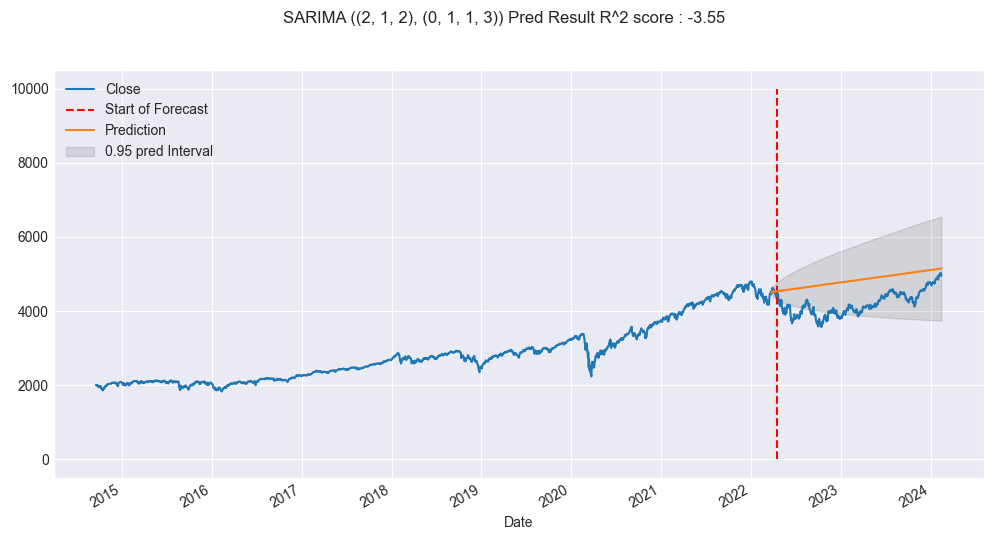

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax =ax)
ax.vlines('2022-04-15', 0, 10000, linestyle='--',color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')

ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optim[0][0]} Pred Result R^2 score : {round(r2, 2)}')
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00480D+00    |proj g|=  4.07108D-02


 This problem is unconstrained.



At iterate    5    f=  4.96465D+00    |proj g|=  1.13931D-02

At iterate   10    f=  4.89789D+00    |proj g|=  9.35633D-02

At iterate   15    f=  4.89602D+00    |proj g|=  3.73535D-03

At iterate   20    f=  4.89597D+00    |proj g|=  2.17602D-02

At iterate   25    f=  4.88555D+00    |proj g|=  2.88077D-02

At iterate   30    f=  4.86546D+00    |proj g|=  6.16896D-02

At iterate   35    f=  4.85933D+00    |proj g|=  7.06375D-03

At iterate   40    f=  4.85710D+00    |proj g|=  1.09846D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     61      1     0     0   1.902D-06   4.857D+00
  F =   4.85708690690

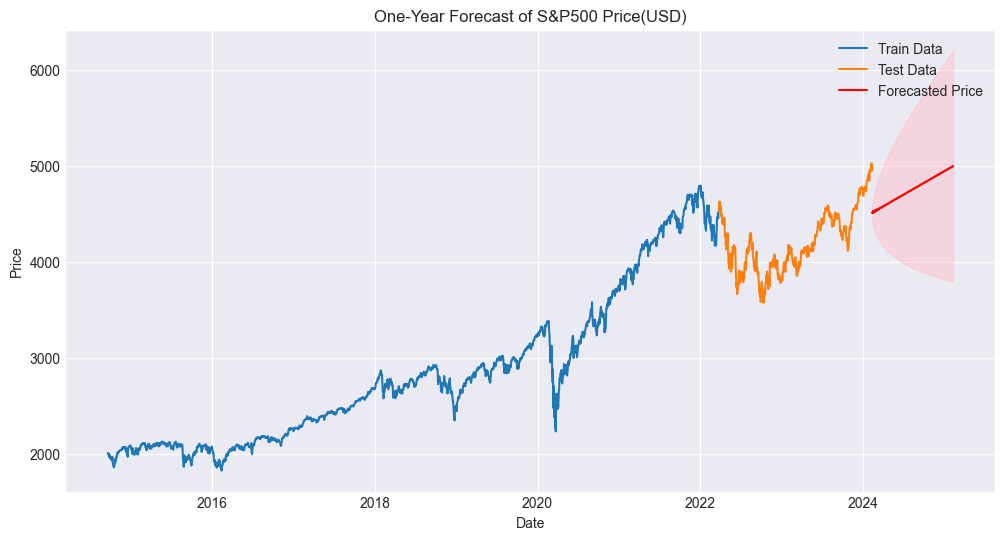

In [23]:
model = SARIMAX(train_data['Close'].values, order=optim[0][0][0], seasonal_order=optim[0][0][1])
model_fit = model.fit()
model_fit.summary()

# 1년 후의 가격 예측
forecast_period = 365  # 1년에 해당하는 일수
pred = model_fit.get_forecast(steps=forecast_period)
pred_val = pred.predicted_mean
pred_ub = pred.conf_int()[:, 0]
pred_lb = pred.conf_int()[:, 1]

# 예측 인덱스 생성
pred_index = pd.date_range(start=test_data.index[-1], periods=forecast_period, freq='D')

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Close'], label='Train Data')
plt.plot(test_data.index, test_data['Close'], label='Test Data')
plt.plot(pred_index, pred_val, color='red', label='Forecasted Price')
plt.fill_between(pred_index, pred_lb, pred_ub, color='pink', alpha=0.5)
plt.title('One-Year Forecast of S&P500 Price(USD)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



In [24]:
# Current stock price
current_price = test_data.iloc[-1]['Close']

# Stock price one year later
future_price = pred_val[-1]

# Calculate the profit rate
profit_rate = ((future_price - current_price) / current_price) * 100

print(f"Current stock price: {current_price}")
print(f"Estimated stock price one year later: {future_price}")
print(f"One-year profit rate: {profit_rate:.2f}%")


Current stock price: 4953.169921875
Estimated stock price one year later: 5000.401382283955
One-year profit rate: 0.95%


In [30]:
mse = mean_squared_error(test_data, pred_index)


ValueError: Found input variables with inconsistent numbers of samples: [6, 365]